In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np
from tqdm.notebook import tqdm

In [2]:
SAMPLE_SIZE = 10e3

In [3]:
df = pd.read_csv("data/rows.csv", 
        nrows=SAMPLE_SIZE, 
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
        infer_datetime_format=True,
        dtype={"store_and_fwd_flag": "bool"},
        true_values=["Y"],
        false_values=["N"],
)
df = df.rename(
    columns = {
        "VendorID": "vendor_id", 
        "RatecodeID": "ratecode_id",
        "PULocationID": "pickup_loc_id",
        "DOLocationID": "dropoff_loc_id"
    }
)

In [182]:
G = nx.from_pandas_edgelist(
    df_summary, 
    source="pickup_loc_id",
    target="dropoff_loc_id",
    edge_attr=True,
    create_using=nx.DiGraph
)

In [185]:
geo = gp.read_file("data/NYC Taxi Zones/geo_export_38097766-152c-469f-95c0-313056068b21.shp")

In [186]:
for node in G.nodes:
    try:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == node].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == node].zone.iloc[0]
    except:
        G.nodes[node]['pos'] = list(geo[geo["objectid"] == 1].centroid.iloc[0].coords)[0]
        G.nodes[node]['zone'] = geo[geo["objectid"] == 1].zone.iloc[0]

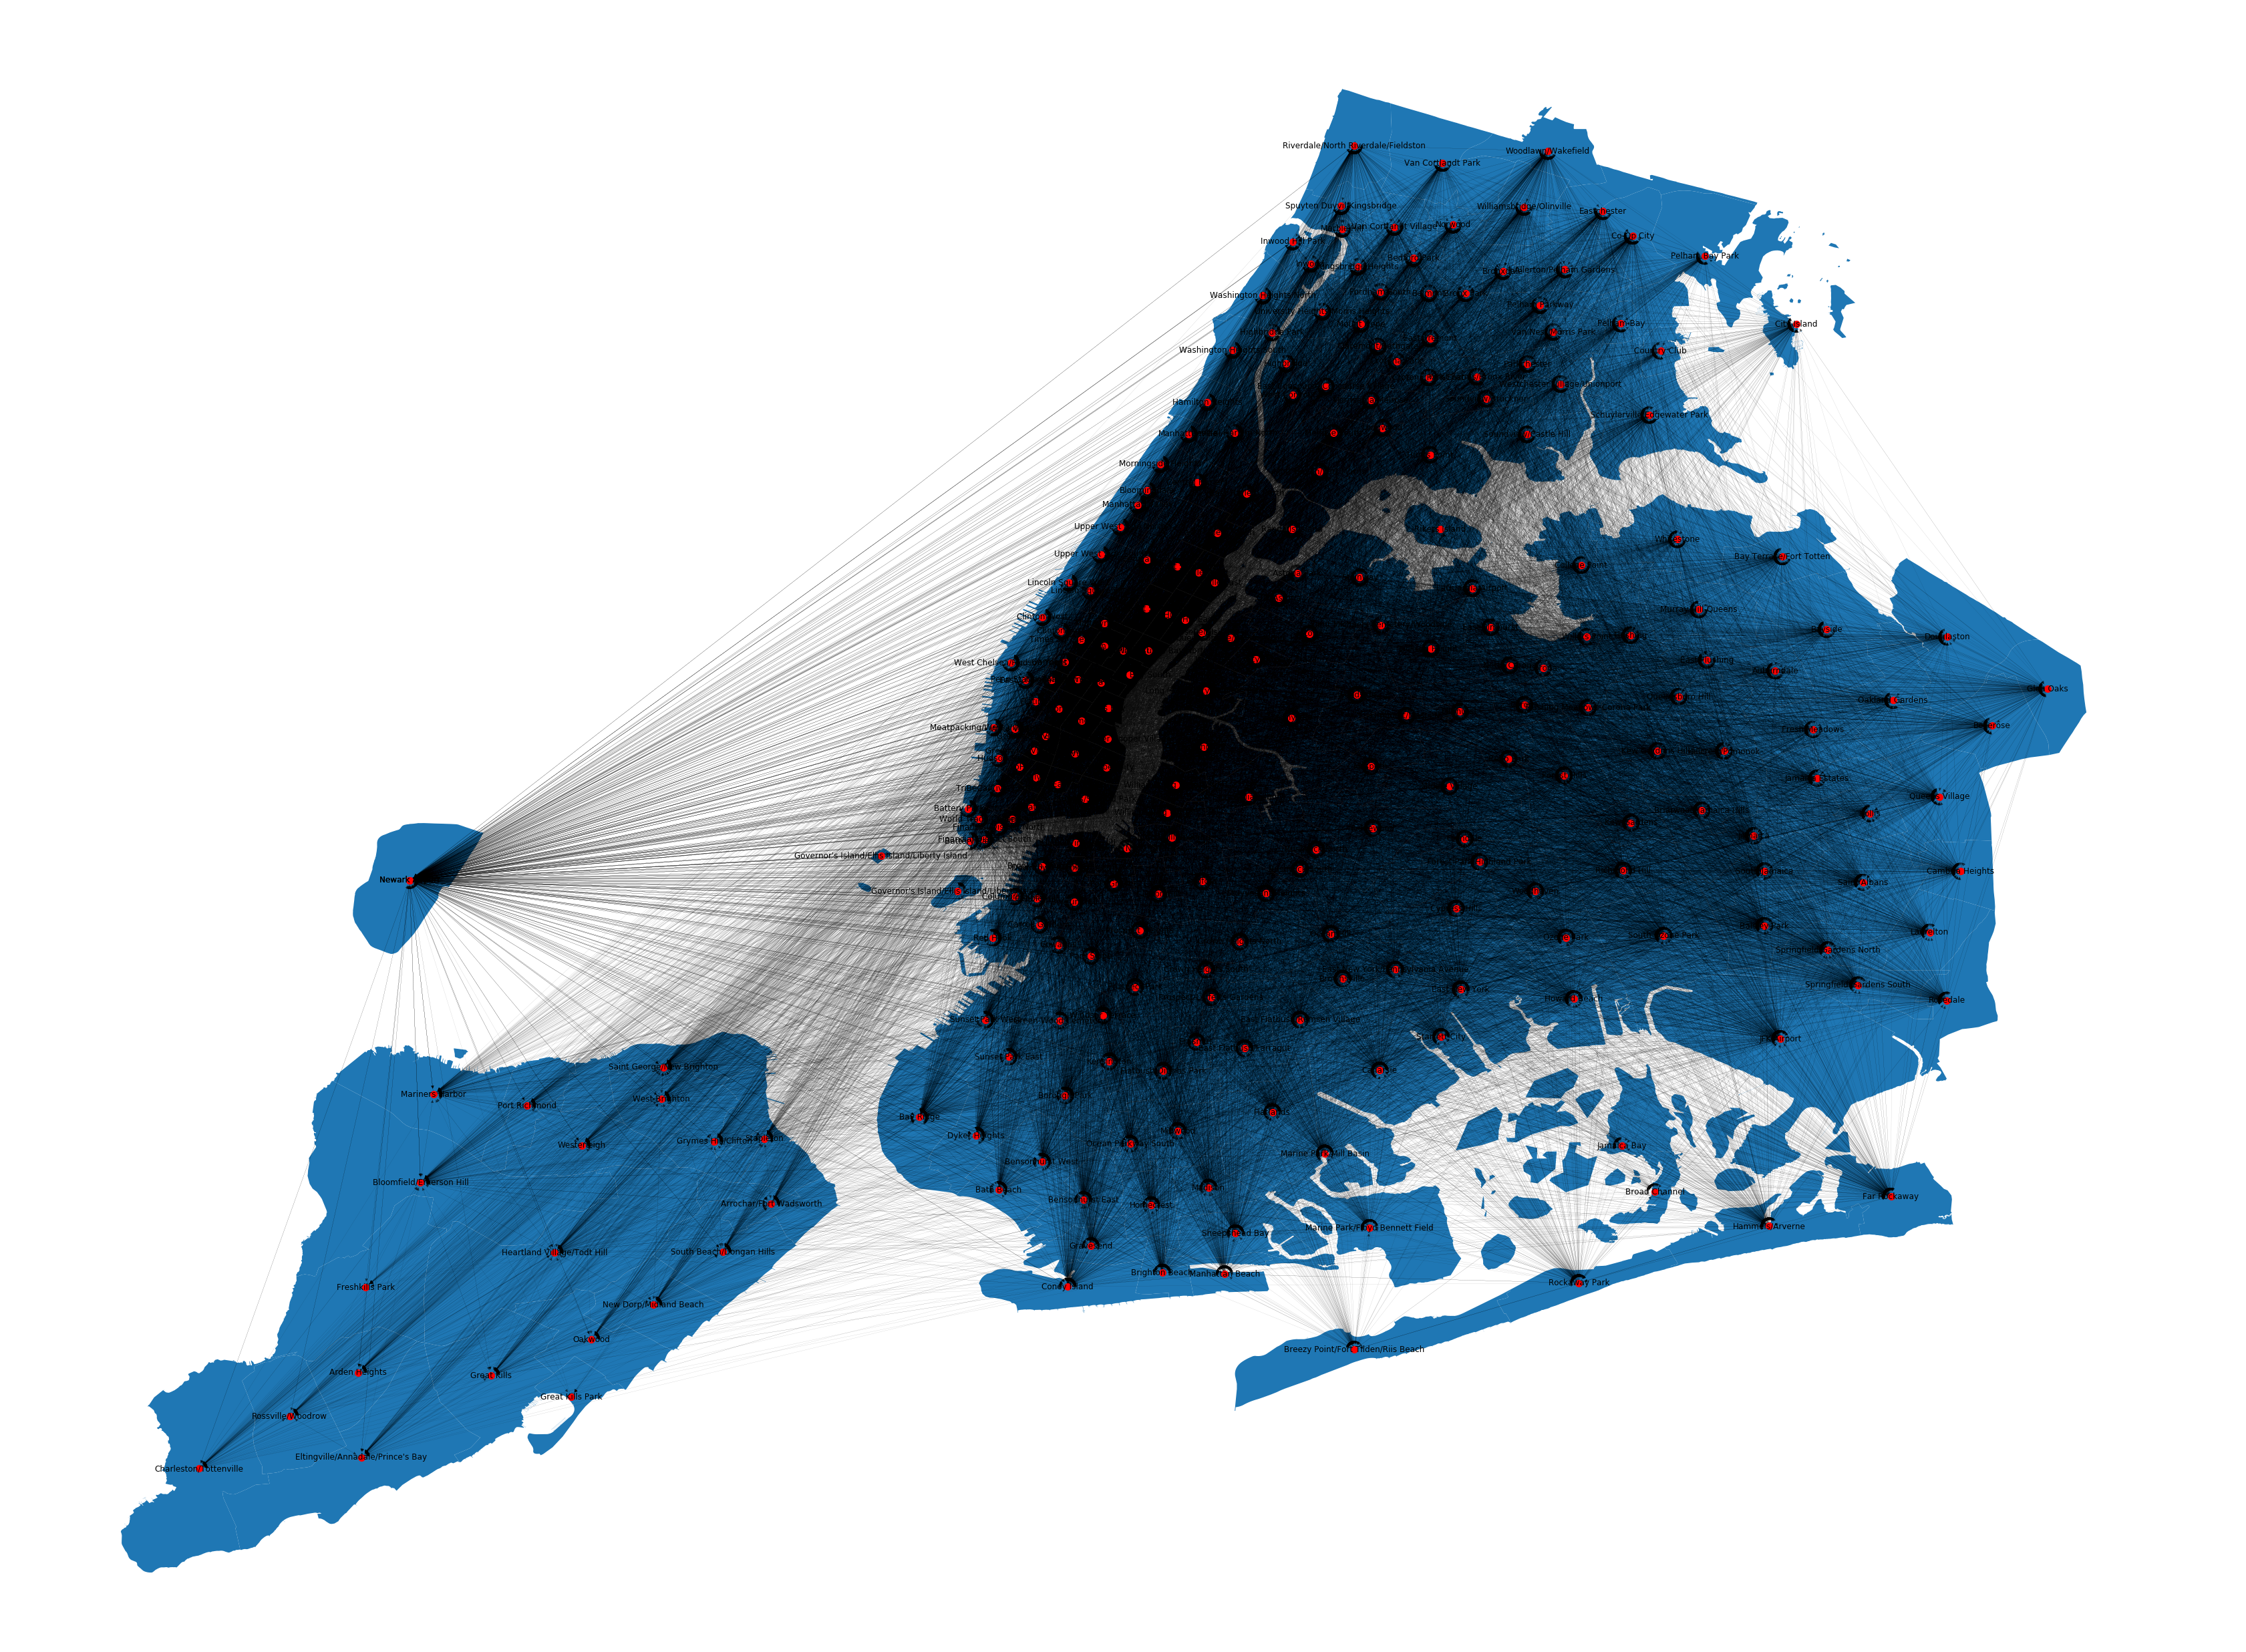

In [187]:
plt.figure(1,figsize=(60,60)) 
plt.axis('off')
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, "pos"), node_size=100, node_color="red")
nx.draw_networkx_edges(G, nx.get_node_attributes(G, "pos"), alpha = 0.6, width=0.1)
nx.draw_networkx_labels(G, nx.get_node_attributes(G, "pos"), labels = nx.get_node_attributes(G, "zone"))

ax = plt.gca()
geo.plot(ax = ax)
plt.show()

In [59]:
from tqdm.notebook import trange, tqdm
import numpy as np
i = 0
from collections import defaultdict
d = defaultdict(lambda:defaultdict(np.double))

for line in tqdm(open("data/2018_Yellow_Taxi_Trip_Data.csv"), total=112234627):
    line = line[0:-1]
    csv_row = line.split(",")
    i += 1
    if i == 1:
        continue
    
    if int(csv_row[5]) == 99:
        continue
        
    d[(csv_row[7], csv_row[8])]["count"] += 1
    d[(csv_row[7], csv_row[8])]["passenger_count_sum"] += int(csv_row[3])
    d[(csv_row[7], csv_row[8])]['trip_distance_sum'] += float(csv_row[4])
    
    
    if type(d[(csv_row[7], csv_row[8])]["ratecode_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["ratecode_count"] = np.zeros(6)
    d[(csv_row[7], csv_row[8])]['ratecode_count'][int(csv_row[5])-1] += 1
    
    if type(d[(csv_row[7], csv_row[8])]["payment_type_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["payment_type_count"] = np.zeros(6)
    d[(csv_row[7], csv_row[8])]['payment_type_count'][int(csv_row[9])-1] += 1
    
    d[(csv_row[7], csv_row[8])]['fare_amount_sum'] += float(csv_row[10])
    d[(csv_row[7], csv_row[8])]['tip_amount_sum'] += float(csv_row[14])
    if float(csv_row[15]) > 0:
        d[(csv_row[7], csv_row[8])]['tolls_count'] += 1
    d[(csv_row[7], csv_row[8])]['total_amount_sum'] += float(csv_row[-1])
    if float(csv_row[-1]) > d[(csv_row[7], csv_row[8])]['total_amount_max']:
        d[(csv_row[7], csv_row[8])]['total_amount_max'] = float(csv_row[-1])
        
    if type(d[(csv_row[7], csv_row[8])]["hour_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["hour_count"] = np.zeros(24)
        
    hour = int(csv_row[1][11:13])
    if csv_row[1][-2:-1] == 'P':
        hour += 12
        if hour == 24:
            hour = 0
    d[(csv_row[7], csv_row[8])]['hour_count'][hour] += 1
    
    if type(d[(csv_row[7], csv_row[8])]["month_count"]) is not np.ndarray:
        d[(csv_row[7], csv_row[8])]["month_count"] = np.zeros(12)
    d[(csv_row[7], csv_row[8])]["month_count"][int(csv_row[1][0:2])-1] += 1  


'\n{\n    "count": 0\n    "passenger_count_sum": 0,\n    "trip_distance_sum": 0,\n    "ratecode_count": [0,0,0,0,0,0],\n    "payment_type_count": [0,0,0,0,0,0],\n    "fare_amount_sum": 0,\n    "tip_amount_sum": 0,\n    "tolls_count": 0,\n    "total_amount_sum": 0,\n    "total_amount_max": 0,\n    "total_amount_min": np.inf,\n    "hour_count": ass\'\n    "month_count": bass\n}\n'

In [140]:
df_summary = pd.DataFrame.from_dict(d, orient="index")

In [141]:
df_summary = df_summary.reset_index()

In [142]:
df_summary = df_summary.rename(
    columns={
        "level_0": "pickup_loc_id", 
        "level_1": "dropoff_loc_id"
    }
)

In [144]:
df_summary[list(map(lambda i: f"ratecode_{i}_count", range(1,7)))] = pd.DataFrame(df_summary["ratecode_count"].tolist(), index = df_summary.index, dtype = int)

In [145]:
df_summary[list(map(lambda i: f"payment_type_{i}_count", range(1,7)))] = pd.DataFrame(df_summary["payment_type_count"].tolist(), index = df_summary.index, dtype = int)

In [146]:
df_summary[list(map(lambda i: f"hour_{i}_count", range(0,24)))] = pd.DataFrame(df_summary["hour_count"].tolist(), index = df_summary.index, dtype = int)

In [147]:
df_summary[list(map(lambda i: f"month_{i}_count", range(1,13)))] = pd.DataFrame(df_summary["month_count"].tolist(), index = df_summary.index, dtype = int)

In [148]:
df_summary = df_summary.drop(columns=["ratecode_count", "payment_type_count", "hour_count", "month_count"])

In [149]:
df_summary = df_summary.fillna(0)

In [150]:
df_summary = df_summary.astype(
    {
        "pickup_loc_id": int,
        "dropoff_loc_id": int,
        "count": int,
        "passenger_count_sum": int,
        "tolls_count": int,
    }
)

In [152]:
df_summary.trip_distance_sum = df_summary.trip_distance_sum / 0.62137119

In [157]:
columns_to_round = df_summary.columns[df_summary.dtypes == np.float64]
df_summary = df_summary.round(dict(zip(columns_to_round, np.repeat(2, len(columns_to_round)))))

In [158]:
columns = ['passenger_count_', "trip_distance_", "fare_amount_", "total_amount_", "tip_amount_"]
for column in columns:
    df_summary[column + "mean"] = df_summary[column + "sum"] / df_summary["count"]

In [159]:
df_summary.to_csv("summary.csv", sep=";", index = False)

In [ ]:
df_summary

In [2]:
df = pd.read_csv("summary.csv", sep=";")

(array([4.6787e+04, 6.6300e+02, 3.0500e+02, 2.0300e+02, 1.3000e+02,
        8.2000e+01, 6.0000e+01, 5.1000e+01, 3.6000e+01, 3.5000e+01,
        2.5000e+01, 1.7000e+01, 2.2000e+01, 1.0000e+01, 5.0000e+00,
        5.0000e+00, 4.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [20]:
G = nx.from_pandas_edgelist(
    df, 
    source="pickup_loc_id",
    target="dropoff_loc_id",
    edge_attr=True,
    create_using=nx.DiGraph
)

(array([6.126e+03, 0.000e+00, 0.000e+00, 0.000e+00, 3.640e+03, 0.000e+00,
        0.000e+00, 2.528e+03, 0.000e+00, 1.889e+03, 0.000e+00, 1.544e+03,
        1.240e+03, 1.133e+03, 9.630e+02, 8.510e+02, 1.474e+03, 6.370e+02,
        1.138e+03, 1.350e+03, 7.470e+02, 1.035e+03, 1.161e+03, 9.570e+02,
        8.550e+02, 8.510e+02, 1.094e+03, 8.390e+02, 8.430e+02, 7.320e+02,
        8.240e+02, 6.950e+02, 6.770e+02, 6.420e+02, 6.790e+02, 6.100e+02,
        5.480e+02, 5.520e+02, 5.350e+02, 4.740e+02, 5.050e+02, 4.500e+02,
        3.860e+02, 3.640e+02, 3.310e+02, 2.880e+02, 3.180e+02, 2.970e+02,
        2.940e+02, 2.580e+02, 2.550e+02, 2.510e+02, 2.380e+02, 2.110e+02,
        2.150e+02, 2.210e+02, 2.150e+02, 2.140e+02, 2.050e+02, 2.240e+02,
        1.780e+02, 1.750e+02, 1.490e+02, 1.870e+02, 1.460e+02, 1.340e+02,
        1.370e+02, 1.560e+02, 1.530e+02, 1.210e+02, 1.430e+02, 1.160e+02,
        1.170e+02, 1.180e+02, 1.010e+02, 9.200e+01, 1.090e+02, 9.100e+01,
        6.800e+01, 6.400e+01, 5.800e+0

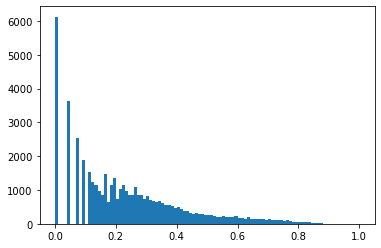

In [27]:
colors = []
m = max(np.log(df["count"])
for u,v in G.edges():
    x = np.log(G[u][v]["count"])
    
    if x > 0.7:
        o = 1
    elif x > 0.5:
        o = 0.5
    elif x > 0.1:
        o = 0.2
    else:
        o = 0.05
    colors.append(o)  




In [48]:
threshold = 1000
top_n_df =  df.sort_values(by="count", ascending = False)[0:threshold]
bot_n_df =  df.sort_values(by="count", ascending = True)[0:threshold]

pickup_loc_id  dropoff_loc_id    count  passenger_count_sum  \
182            264             264  1450857              2066616   
218            237             236   661113              1036057   
57             236             236   561700               878835   
148            236             237   555840               869150   
237            237             237   523642               809056   
..             ...             ...      ...                  ...   
950            164             170   151625               237411   
445            142             236   151583               241122   
698            236             142   151026               238060   
887            142             143   150424               236771   
104            162             186   149651               240836   

     trip_distance_sum  fare_amount_sum  tip_amount_sum  tolls_count  \
182         6417894.09      18618206.40       412302.39      1449095   
218         1111093.47       4171030.73          351.87       660837   
57           554429.49       2873179.91         7118.27       560575   
148          932974.20       3898880.58          290.25       555609   
237          546286.50       2868013.70         5153.31       522432   
..                 ...              ...             ...          ...   
950          159068.98        859403.66          822.60       151337   
445          519816.09       1624656.30           70.52       151565   
698          484124.89       1538334.35          131.36       151016   
887          177935.77        843710.82          340.41       150297   
104          357308.79       1561101.70          122.00       149631   

     total_amount_sum  total_amount_max  ...  month_8_count  month_9_count  \
182       23284395.46         403408.18  ...          82244          83643   
218        5558981.24            261.04  ...          33574          50466   
57         3942183.55            980.30  ...          27136          40659   
148        5093714.14            420.80  ...          28773          43120   
237        3863561.40            980.36  ...          29831          39343   
..                ...               ...  ...            ...            ...   
950        1171408.12            160.80  ...          11965          10697   
445        2041880.73            263.80  ...           7284          10922   
698        1938874.70            384.30  ...           7615          10966   
887        1151739.51            100.00  ...           8715          10414   
104        1952773.16            290.80  ...          11707          10259   

     month_10_count  month_11_count  month_12_count  passenger_count_mean  \
182          117024          122217          134517              1.424411   
218           59827           55618           55247              1.567141   
57            48157           47060           47771              1.564599   
148           49658           46750           47019              1.563669   
237           45317           44012           44258              1.545056   
..              ...             ...             ...                   ...   
950           11197           10559           10607              1.565777   
445           13776           12690           12785              1.590693   
698           13759           12562           12570              1.576285   
887           11865           12717           12957              1.574024   
104           11266            9794           10606              1.609318   

     trip_distance_mean  fare_amount_mean  total_amount_mean  tip_amount_mean  
182            4.423519         12.832558          16.048718         0.284179  
218            1.680641          6.309104           8.408519         0.000532  
57             0.987056          5.115150           7.018308         0.012673  
148            1.678494          7.014394           9.163993         0.000522  
237            1.043244          5.477051           7.378250 

In [5]:
i = 0
x = 0
y = 0
for line in tqdm(open("data/2018_Yellow_Taxi_Trip_Data.csv"), total=112234627):
    line = line[0:-1]
    csv_row = line.split(",")
    i += 1
    if i == 1:
        continue
    
    if int(csv_row[5]) == 99:
        continue
    
    if int(csv_row[7]) == 168 and int(csv_row[8]) == 149:
        x += 1
        print("x", x)
    if int(csv_row[7]) == 46 and int(csv_row[8]) == 54:
        y += 1
        print("y", y)

x 1
y 1



In [6]:
i = 0
x = 0
y = 0
for line in tqdm(open("data/2018_Yellow_Taxi_Trip_Data.csv"), total=112234627):
    line = line[0:-1]
    csv_row = line.split(",")
    i += 1
    if i == 1:
        continue
    
    if int(csv_row[5]) == 99:
        continue
    
    if int(csv_row[7]) == 39 and int(csv_row[8]) == 5:
        x += 1
        print("x", x)
    if int(csv_row[7]) == 165 and int(csv_row[8]) == 241:
        y += 1
        print("y", y)

y 1
x 1

